In [11]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


spark = SparkSession.builder.config("spark.driver.host", "localhost").config("spark.python.worker.reuse", "false").getOrCreate()
file_path = 'file:///C:/Users/seanz/VSCode_WS/BigData/NFL_PBP_V1.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

df = df.withColumn(
    'play_success', 
    F.when(
        (F.col('play_type') == 'run') & (F.col('rush_attempt') == 1) & (F.col('yards_gained') >= 4), 1
    ).when(
        (F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1) & (F.col('yards_gained') >= 4), 1
    ).otherwise(0)
)

window_spec = Window.partitionBy('game_id', 'posteam').orderBy('play_id')
df = df.withColumn(
    'cumulative_rush_attempts', 
    F.sum(F.when((F.col('play_type') == 'run') & (F.col('rush_attempt') == 1), 1).otherwise(0)).over(window_spec)
)

df = df.withColumn(
    'cumulative_pass_attempts', 
    F.sum(F.when((F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1), 1).otherwise(0)).over(window_spec)
)

df = df.withColumn(
    'cumulative_rush_successes', 
    F.sum(F.when(
        (F.col('play_type') == 'run') & (F.col('rush_attempt') == 1) & (F.col('yards_gained') >= 4), 1).otherwise(0)
    ).over(window_spec)
)

df = df.withColumn(
    'cumulative_pass_successes', 
    F.sum(F.when(
        (F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1) & (F.col('yards_gained') >= 4), 1).otherwise(0)
    ).over(window_spec)
)

df = df.withColumn(
    'rush_success_rate', 
    F.when(F.col('cumulative_rush_attempts') > 0, F.col('cumulative_rush_successes') / F.col('cumulative_rush_attempts')).otherwise(0)
)

df = df.withColumn(
    'pass_success_rate', 
    F.when(F.col('cumulative_pass_attempts') > 0, F.col('cumulative_pass_successes') / F.col('cumulative_pass_attempts')).otherwise(0)
)

df = df.withColumn('posteam_leading', F.col('score_differential_post') > 0)
df = df.withColumn('posteam_trailing', F.col('score_differential_post') < 0)
df = df.withColumn('yards_gained', F.col('yards_gained').cast('float'))
df = df.withColumn('shotgun', F.col('shotgun').cast('float'))
df = df.withColumn('no_huddle', F.col('no_huddle').cast('float'))
df = df.withColumn('timeout', F.col('timeout').cast('float'))
df = df.withColumn('posteam_timeouts_remaining', F.col('posteam_timeouts_remaining').cast('float'))
df = df.withColumn('defteam_timeouts_remaining', F.col('defteam_timeouts_remaining').cast('float'))
offensive_playtypes = ['field_goal', 'run', 'punt', 'pass', 'qb_kneel', 'qb_spike']
df = df.filter(df.play_type.isin(offensive_playtypes))

df_indexed = df.withColumn('play_type_index', 
                           F.when(F.col('play_type') == 'pass', 0)
                            .when(F.col('play_type') == 'run', 1)
                            .when(F.col('play_type') == 'punt', 2)
                            .when(F.col('play_type') == 'field_goal', 3)
                            .when(F.col('play_type') == 'qb_kneel', 4)
                            .when(F.col('play_type') == 'qb_spike', 5)
                            .otherwise(-1))  
        
feature_columns = [ 'yardline_100', 'game_seconds_remaining', 'qtr', 'down', 'goal_to_go', 'ydstogo', 'yards_gained',
                   'shotgun', 'no_huddle', 'qb_kneel', 'qb_spike', 'timeout', 'posteam_timeouts_remaining', 
                   'defteam_timeouts_remaining', 'score_differential_post', 'rush_attempt', 'pass_attempt', 
                   'field_goal_attempt', 'punt_attempt', 'posteam_leading', 'posteam_trailing', 'rush_success_rate',
                   'pass_success_rate']


assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_vector = assembler.transform(df_indexed)

games = df_vector.select("game_id").distinct().collect()  
train_games = games[:int(0.8 * len(games))] 
test_games = games[int(0.8 * len(games)):]

train_df = df_vector.filter(col("game_id").isin([game["game_id"] for game in train_games]))
test_df = df_vector.filter(col("game_id").isin([game["game_id"] for game in test_games]))

input_size = len(feature_columns)
num_classes = df_vector.select("play_type_index").distinct().count()

layers = [input_size, 10, num_classes]
print(f"Network layers: {layers}")

mlp = MultilayerPerceptronClassifier(
    labelCol="play_type_index",
    featuresCol="features",
    layers=layers,
    blockSize=128,
    seed=42,
    maxIter=200,
    predictionCol="prediction",
    probabilityCol="probability",
    rawPredictionCol="rawPrediction",
    solver="l-bfgs",
    stepSize=0.03,
    tol=1e-06
)

mlp_model = mlp.fit(train_df)
predictions = mlp_model.transform(test_df)
predictions.select("play_type_index", "prediction", "probability").show(50, truncate=False)

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol='play_type_index', predictionCol='prediction', metricName='accuracy')
evaluator_precision = MulticlassClassificationEvaluator(labelCol='play_type_index', predictionCol='prediction', metricName='weightedPrecision')
evaluator_recall = MulticlassClassificationEvaluator(labelCol='play_type_index', predictionCol='prediction', metricName='weightedRecall')
evaluator_f1 = MulticlassClassificationEvaluator(labelCol='play_type_index', predictionCol='prediction', metricName='f1')

accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print(f"Multilayer Perceptron Classifier Results:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1 Score: {f1_score:.4f}")

Network layers: [23, 10, 6]
+---------------+----------+--------------------------------------------------------------------------------------------------------------------------------+
|play_type_index|prediction|probability                                                                                                                     |
+---------------+----------+--------------------------------------------------------------------------------------------------------------------------------+
|0              |0.0       |[0.9906134148414932,0.009373369545070195,8.197252786127752E-7,1.2391819243345618E-5,1.1955693919442152E-9,2.873345157591285E-9] |
|1              |1.0       |[0.07753164531920168,0.6701668699369585,0.1993441604807039,0.05292465204250839,2.8347166517917627E-5,4.325054109585664E-6]      |
|0              |0.0       |[0.9876557715608489,0.01232349013878163,1.4990278322439412E-6,1.9233008411409675E-5,1.9892660943837188E-9,4.274859893802529E-9] |
|2              |1.0    

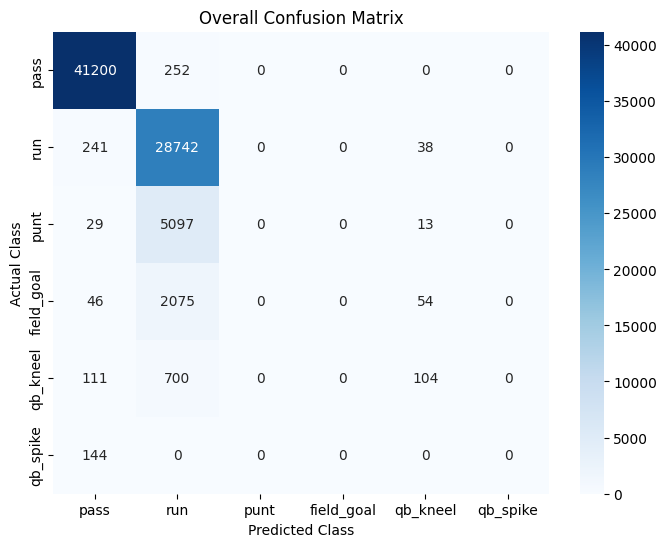

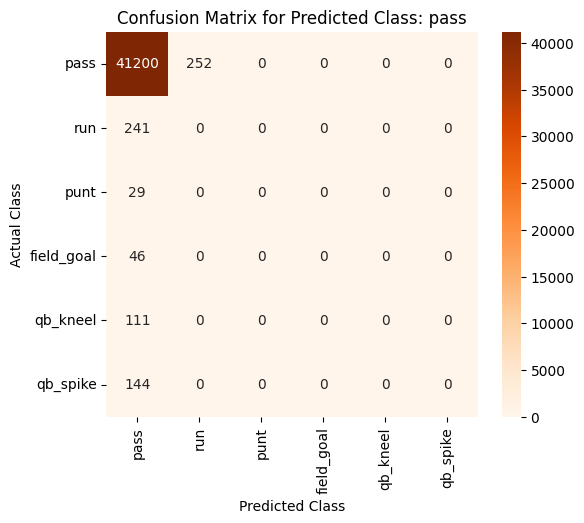

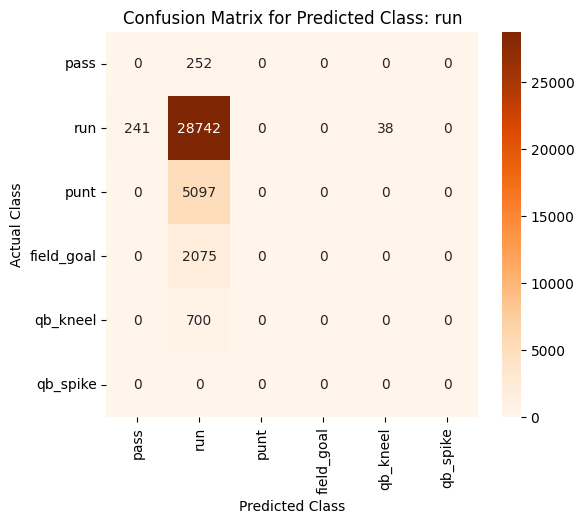

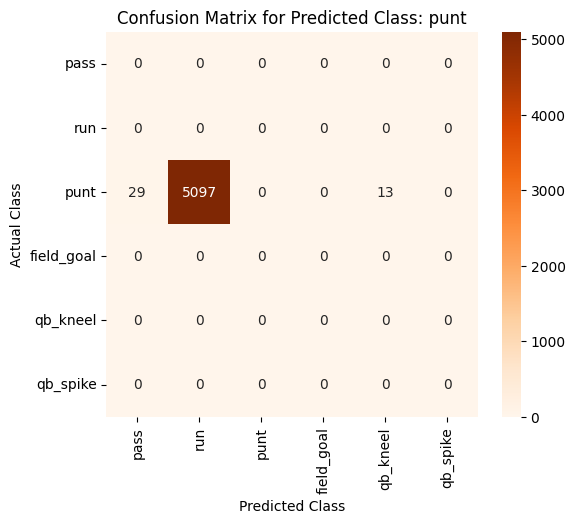

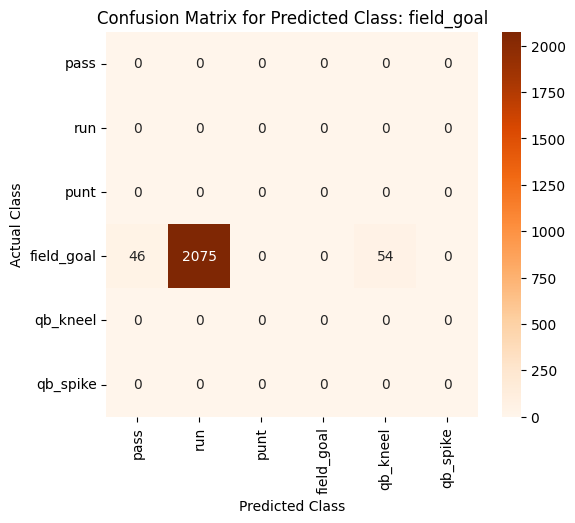

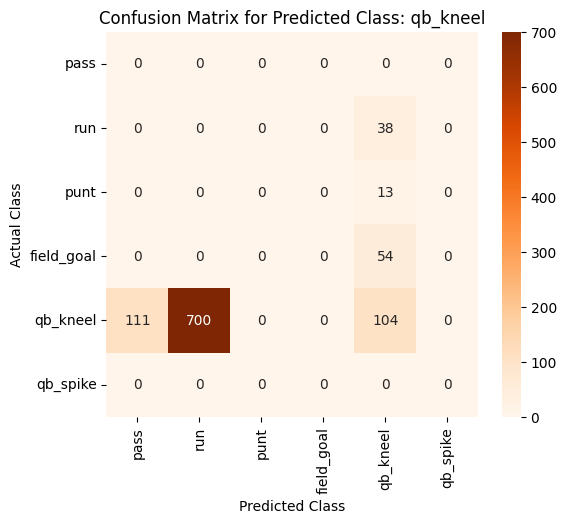

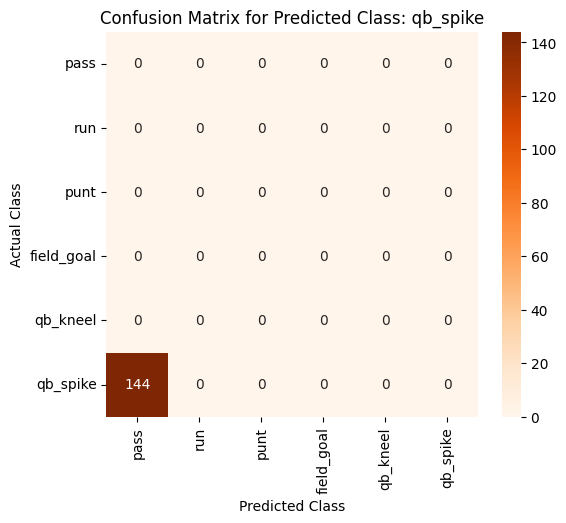

In [12]:

# Convert Spark DataFrame to Pandas
predictions_pdf = predictions.select("play_type_index", "prediction").toPandas()

# Define class labels
class_labels = ["pass", "run", "punt", "field_goal", "qb_kneel", "qb_spike"]

# Compute the overall confusion matrix
conf_matrix = confusion_matrix(predictions_pdf["play_type_index"], predictions_pdf["prediction"])

# Plot Overall Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Overall Confusion Matrix")
plt.show()

# Plot Individual Confusion Matrices
for i, label in enumerate(class_labels):
    # Create a binary confusion matrix for each predicted class
    binary_conf_matrix = np.zeros_like(conf_matrix)
    binary_conf_matrix[i, :] = conf_matrix[i, :]  # Only keep predictions for class i
    binary_conf_matrix[:, i] = conf_matrix[:, i]  # Only keep actual occurrences of class i

    plt.figure(figsize=(6, 5))
    sns.heatmap(binary_conf_matrix, annot=True, fmt="d", cmap="Oranges", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.title(f"Confusion Matrix for Predicted Class: {label}")
    plt.show()

In [ ]:
numeric_labels = [0, 1, 2, 3]

def compute_class_metrics(predictions, class_index):
    evaluator_precision = MulticlassClassificationEvaluator(
        labelCol="play_type_index", predictionCol="prediction", metricName="precisionByLabel")
    evaluator_recall = MulticlassClassificationEvaluator(
        labelCol="play_type_index", predictionCol="prediction", metricName="recallByLabel")
    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol="play_type_index", predictionCol="prediction", metricName="fMeasureByLabel")

    precision = evaluator_precision.evaluate(predictions, {evaluator_precision.metricLabel: class_index})
    recall = evaluator_recall.evaluate(predictions, {evaluator_recall.metricLabel: class_index})
    f1 = evaluator_f1.evaluate(predictions, {evaluator_f1.metricLabel: class_index})

    return precision, recall, f1

class_metrics = {}
for class_index in numeric_labels:
    precision, recall, f1 = compute_class_metrics(predictions, class_index)
    class_metrics[class_index] = {"Precision": precision, "Recall": recall, "F1-Score": f1}

class_metrics_df = pd.DataFrame.from_dict(class_metrics, orient="index")

print("Classification Report:")
print(class_metrics_df)

Classification Report:
   Precision    Recall  F1-Score
0   0.986330  0.993921  0.990111
1   0.779634  0.990386  0.872463
2   0.000000  0.000000  0.000000
3   0.000000  0.000000  0.000000
4   0.497608  0.113661  0.185053
5   0.000000  0.000000  0.000000


In [16]:
play_type_distribution = df_indexed.groupBy("play_type_index").count().orderBy("play_type_index")

play_type_distribution.show()

+---------------+------+
|play_type_index| count|
+---------------+------+
|              0|207184|
|              1|146702|
|              2| 26260|
|              3| 10819|
|              4|  4271|
|              5|   762|
+---------------+------+

